# Slow Fast Moving Average

In [1]:
using Trading
using Trading.Strategies
using Trading.Basic
using Trading.Indicators
using Trading.Portfolio

struct SlowFast <: System end
Overseer.requested_components(::SlowFast) = (SMA{50, Close}, SMA{200, Close})

function Overseer.update(s::SlowFast, t::Trader, ticker_ledgers)
    for ticker_ledger in ticker_ledgers
        ticker = ticker_ledger.ticker
        for e in new_entities(ticker_ledger, s)
            lag_e = lag(e, 1)

            if lag_e === nothing
                continue
            end

            sma_50  = e[SMA{50, Close}].sma
            sma_200 = e[SMA{200, Close}].sma

            lag_sma_50 = lag_e[SMA{50, Close}].sma
            lag_sma_200 = lag_e[SMA{200, Close}].sma

            if sma_50 > sma_200 && lag_sma_50 < lag_sma_200
                Entity(t, Sale(ticker, 1.0))
            elseif sma_50 < sma_200 && lag_sma_50 > lag_sma_200
                Entity(t, Purchase(ticker, 1.0))
            end
        end
    end
end

The `Inf` values for the quantity of stocks to trade in the `Sale` and `Purchase` constructors signifies that we want to buy as many stocks as our cash balance allows for.

In [2]:
broker = HistoricalBroker(AlpacaBroker(ENV["ALPACA_KEY_ID"], ENV["ALPACA_SECRET"]))

strategy = Strategy(:slowfast, [SlowFast()], tickers=["MSFT", "AAPL"])

trader = BackTester(broker, start = DateTime("2015-01-01T00:00:00"),
                            stop = DateTime("2020-01-01T00:00:00"),
                            dt = Day(1),
                            strategies = [strategy],
                            cash = 1000,
                            only_day=false)
start(trader)

[ Info: Fetching historical data
⠋ Simulating... 	 Time: 0:00:01
  t:      2015-12-02T06:00:00
  value:  1000.0[ Info: Closed Data Stream
[ Info: Closed Trading Stream
✓ Simulating... 	 Time: 0:00:03


Trader

Main task:    Task (failed) @0x00007fa93e8bcb90
Trading task: Task (done) @0x00007fa93e8bc8b0
Data task:    Task (done) @0x00007fa93e8bca20

Portfolio -- positions: -451.34999999999997, cash: 1196.7433333333333, tot: 745.3933333333334

Current positions:
┌────────┬──────────┬─────────┐
│ Ticker │ Quantity │   Value │
├────────┼──────────┼─────────┤
│   MSFT │     -1.0 │  -157.7 │
│   AAPL │     -1.0 │ -293.65 │
└────────┴──────────┴─────────┘

Strategies:

Trades:
┌─────────────────────┬────────┬──────┬──────────┬───────────┬───────────┐
│                Time │ Ticker │ Side │ Quantity │ Avg Price │ Tot Price │
├─────────────────────┼────────┼──────┼──────────┼───────────┼───────────┤
│ 2016-07-30T06:00:00 │   MSFT │ sell │      1.0 │   56.3733 │   56.3733 │
│ 2016-08-09T06:00:00 │   AAPL │ sell │      1.0 │    108.23 │    108.23 │
│ 2018-12-03T06:00:00 │   AAPL │  buy │      1.0 │    184.46 │    184.46 │
│ 2018-12-21T06:00:00 │   MSFT │  buy │      1.0 │    101.63 │    101.63 

After having executed the strategy, we can see some quick overview from the output, but
by converting it to a `TimeArray` we can more easily analyse how the strategy performed

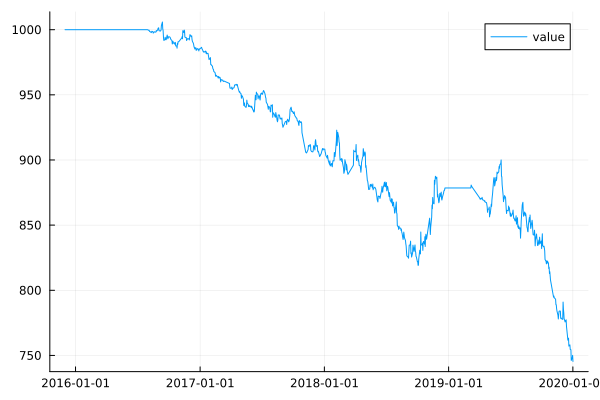

In [3]:
using Plots

ta = TimeArray(trader)

plot(ta[:value])

We see that in this case the strategy didn't work particularly well. In fact it seems that
inverting it, we might get a better result.
We can simply redefine our `update` function as follows:

In [4]:
function Overseer.update(s::SlowFast, t::Trader, ticker_ledgers)
    for ticker_ledger in ticker_ledgers
        ticker = ticker_ledger.ticker
        for e in new_entities(ticker_ledger, s)
            lag_e = lag(e, 1)

            if lag_e === nothing
                continue
            end

            sma_50  = e[SMA{50, Close}].sma
            sma_200 = e[SMA{200, Close}].sma

            lag_sma_50 = lag_e[SMA{50, Close}].sma
            lag_sma_200 = lag_e[SMA{200, Close}].sma

            if sma_50 > sma_200 && lag_sma_50 < lag_sma_200
                Entity(t, Purchase(ticker, Inf))
            elseif sma_50 < sma_200 && lag_sma_50 > lag_sma_200
                Entity(t, Sale(ticker, Inf))
            end
        end
    end
end

We have basically swapped the `Purchase` and `Sale` components.
To execute this updated version we call `reset!` and `start` again.

In [5]:
reset!(trader)
start(trader)

[ Info: Closed Data Stream
[ Info: Closed Trading Stream


Trader

Main task:    Task (failed) @0x00007fa95e9e9710
Trading task: Task (done) @0x00007fa95e9e9430
Data task:    Task (done) @0x00007fa95e9e95a0

Portfolio -- positions: 2523.2, cash: 32.2199999999998, tot: 2555.4199999999996

Current positions:
┌────────┬──────────┬────────┐
│ Ticker │ Quantity │  Value │
├────────┼──────────┼────────┤
│   MSFT │     16.0 │ 2523.2 │
│   AAPL │      0.0 │    0.0 │
└────────┴──────────┴────────┘

Strategies:

Trades:
┌─────────────────────┬────────┬──────┬──────────┬───────────┬───────────┐
│                Time │ Ticker │ Side │ Quantity │ Avg Price │ Tot Price │
├─────────────────────┼────────┼──────┼──────────┼───────────┼───────────┤
│ 2016-07-30T06:00:00 │   MSFT │  buy │     18.0 │   56.3733 │   1014.72 │
│ 2016-08-09T06:00:00 │   AAPL │  buy │     -0.0 │    108.23 │      -0.0 │
│ 2018-12-21T06:00:00 │   MSFT │ sell │     18.0 │    101.63 │   1829.34 │
│ 2019-03-07T06:00:00 │   MSFT │  buy │     16.0 │     111.4 │    1782.4 │
│ 2019-04-25T06:00

and plot the results again, this time taking the relative performances of the portfolio vs the two stocks:

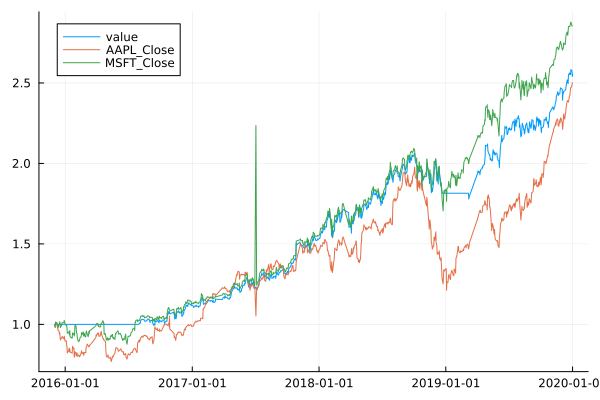

In [6]:
ta = TimeArray(trader)

portfolio_val = ta[:value]./values(ta[:value])[1]
aapl_closes = ta[:AAPL_Close] ./ values(ta[:AAPL_Close])[1]
msft_closes = ta[:MSFT_Close] ./ values(ta[:MSFT_Close])[1]

plot(merge(portfolio_val, aapl_closes, msft_closes))